In [1]:
import numpy as np
import matplotlib.pyplot as plt
import spiceypy as sp
from pathlib import Path

# Load SPICE kernels (notebook is in ./notebooks)
KERNEL_DIR = Path("..") / "spice_kernels"

sp.furnsh(str(KERNEL_DIR / "naif0012.tls"))                     # leap seconds
sp.furnsh(str(KERNEL_DIR / "de440.bsp"))                        # planetary ephemeris
sp.furnsh(str(KERNEL_DIR / "ARTEMIS_P1_DEF_2009022_2012022.bsp"))  # ARTEMIS P1 SPK
sp.furnsh(str(KERNEL_DIR / "ARTEMIS_P2_DEF_2009022_2012022.bsp"))  # ARTEMIS P2 SPK


In [2]:
import spiceypy as sp

# List currently loaded SPICE kernels
num_kernels = sp.ktotal("ALL")
print("Loaded kernels:", num_kernels)

for i in range(num_kernels):
    kernel_path = sp.kdata(i, "ALL")[0]
    print(kernel_path)


Loaded kernels: 4
..\spice_kernels\naif0012.tls
..\spice_kernels\de440.bsp
..\spice_kernels\ARTEMIS_P1_DEF_2009022_2012022.bsp
..\spice_kernels\ARTEMIS_P2_DEF_2009022_2012022.bsp


In [3]:
import spiceypy as sp
from pathlib import Path

# Paths to ARTEMIS SPK kernels
KERNEL_DIR = Path("..") / "spice_kernels"
P1_SPK = KERNEL_DIR / "ARTEMIS_P1_DEF_2009022_2012022.bsp"
P2_SPK = KERNEL_DIR / "ARTEMIS_P2_DEF_2009022_2012022.bsp"

# List NAIF object IDs contained in each SPK
print("ARTEMIS P1 SPK objects:", sp.spkobj(str(P1_SPK)))
print("ARTEMIS P2 SPK objects:", sp.spkobj(str(P2_SPK)))


ARTEMIS P1 SPK objects: <SpiceCell dtype = 2, length = 0, size = 1000, card = 1, is_set = 1, adjust = 0, init = 1, base = 2508837140848, data = 2508837140872>
ARTEMIS P2 SPK objects: <SpiceCell dtype = 2, length = 0, size = 1000, card = 1, is_set = 1, adjust = 0, init = 1, base = 2508832942720, data = 2508832942744>


In [4]:
import spiceypy as sp

def id_to_name(naif_id):
    """Return the SPICE body name for a NAIF ID if available."""
    try:
        return sp.bodc2n(int(naif_id))
    except Exception:
        return None

# Map NAIF IDs in the ARTEMIS P1 SPK to body names (if defined)
for naif_id in sp.spkobj(str(P1_SPK)):
    print(naif_id, id_to_name(naif_id))


-651 None


In [5]:
import numpy as np
import spiceypy as sp

# Extract NAIF IDs from the ARTEMIS SPK kernels
ARTEMIS_P1_ID = int(list(sp.spkobj(str(P1_SPK)))[0])
ARTEMIS_P2_ID = int(list(sp.spkobj(str(P2_SPK)))[0])

# Time interval (within SPK coverage)
t_start = sp.utc2et("2010-06-01T00:00:00")
t_end = sp.utc2et("2012-01-01T00:00:00") 
ets = np.linspace(t_start, t_end, 8000)

def get_trajectory(target_id, observer_id=sp.bodn2c("EARTH BARYCENTER")):
    """
    Return the Cartesian position history of a target relative to an observer
    in the J2000 inertial frame.
    """
    positions = np.empty((len(ets), 3))
    for i, et in enumerate(ets):
        state, _ = sp.spkez(
            target_id,
            et,
            "J2000",
            "NONE",
            observer_id
        )
        positions[i] = state[:3]
    return positions

# Inertial trajectories (J2000)
r_p1_inertial = get_trajectory(ARTEMIS_P1_ID)
r_p2_inertial = get_trajectory(ARTEMIS_P2_ID)


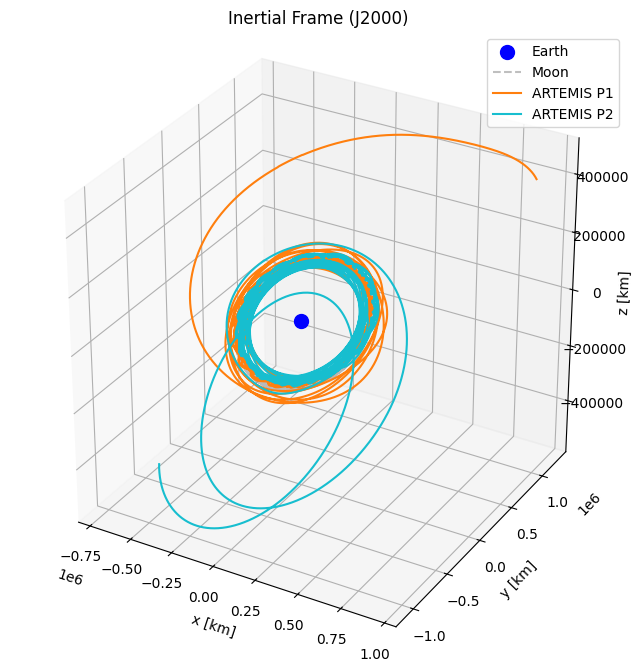

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import spiceypy as sp

# 1. Retrieve data (inertial / J2000)
def get_positions(target_id, observer="EARTH"):
    positions = np.zeros((len(ets), 3))
    for i, et in enumerate(ets):
        # spkez returns (position, velocity); only position [:3] is used
        state, _ = sp.spkez(target_id, et, "J2000", "NONE", sp.bodn2c(observer))
        positions[i] = state[:3]
    return positions

# Retrieve positions for P1, P2, and the Moon
r_p1_inertial = get_positions(ARTEMIS_P1_ID)
r_p2_inertial = get_positions(ARTEMIS_P2_ID)
r_moon_inertial = get_positions(301)  # 301 is the SPICE ID for the Moon

# 2. Plot (inertial frame)
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(projection='3d')

# Earth (origin)
ax.scatter(0, 0, 0, color='blue', s=100, label='Earth')

# Plot trajectories
ax.plot(
    r_moon_inertial[:, 0], r_moon_inertial[:, 1], r_moon_inertial[:, 2],
    color='gray', linestyle='--', alpha=0.5, label='Moon'
)
ax.plot(
    r_p1_inertial[:, 0], r_p1_inertial[:, 1], r_p1_inertial[:, 2],
    label='ARTEMIS P1', color='tab:orange'
)
ax.plot(
    r_p2_inertial[:, 0], r_p2_inertial[:, 1], r_p2_inertial[:, 2],
    label='ARTEMIS P2', color='tab:cyan'
)

ax.set_title("Inertial Frame (J2000)")
ax.set_xlabel("x [km]")
ax.set_ylabel("y [km]")
ax.set_zlabel("z [km]")
ax.legend()
ax.set_box_aspect([1, 1, 1])

plt.show()


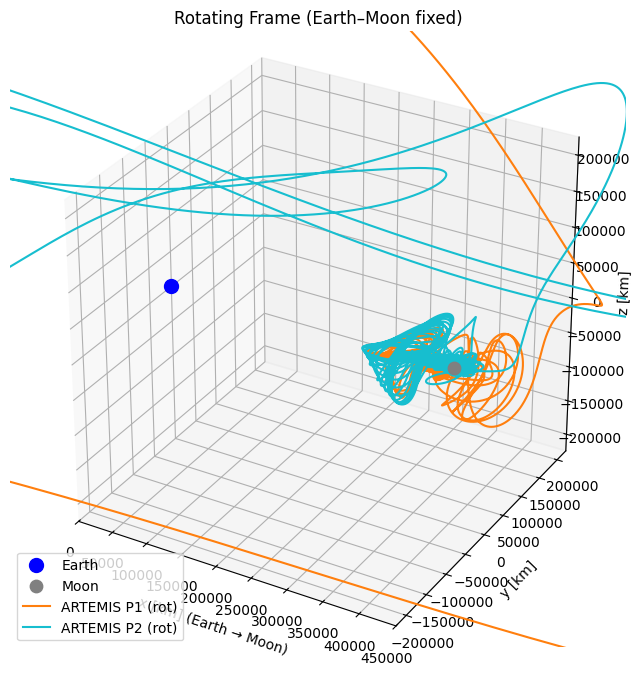

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# 1. Define the transformation to the rotating frame
def transform_to_rotating_frame(r_sat_inertial, r_moon_inertial):
    r_rot = np.zeros_like(r_sat_inertial)

    for i in range(len(r_sat_inertial)):
        r_sat = r_sat_inertial[i]
        r_moon = r_moon_inertial[i]

        # New x-axis: points from Earth to Moon
        x_axis = r_moon / np.linalg.norm(r_moon)

        # Helper vector: J2000 z-axis
        z_j2000 = np.array([0, 0, 1])

        # New y-axis: perpendicular to x and z
        y_axis = np.cross(z_j2000, x_axis)
        y_axis = y_axis / np.linalg.norm(y_axis)

        # New z-axis: perpendicular to x and y (orthogonalization)
        z_axis = np.cross(x_axis, y_axis)

        # Rotation matrix
        R = np.vstack([x_axis, y_axis, z_axis])

        # Transform position
        r_rot[i] = R @ r_sat

    return r_rot

# 2. Apply the transformation
r_p1_rot = transform_to_rotating_frame(r_p1_inertial, r_moon_inertial)
r_p2_rot = transform_to_rotating_frame(r_p2_inertial, r_moon_inertial)
r_moon_rot = transform_to_rotating_frame(r_moon_inertial, r_moon_inertial)

# 3. Plot (rotating frame)
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(projection='3d')

# Bodies
ax.scatter(0, 0, 0, color='blue', s=100, label='Earth')
ax.scatter(r_moon_rot[-1, 0], 0, 0, color='gray', s=80, label='Moon')

# Trajectories
ax.plot(r_p1_rot[:, 0], r_p1_rot[:, 1], r_p1_rot[:, 2], label='ARTEMIS P1 (rot)', color='tab:orange')
ax.plot(r_p2_rot[:, 0], r_p2_rot[:, 1], r_p2_rot[:, 2], label='ARTEMIS P2 (rot)', color='tab:cyan')

ax.set_title("Rotating Frame (Earth–Moon fixed)")
ax.set_xlabel("x [km] (Earth → Moon)")
ax.set_ylabel("y [km]")
ax.set_zlabel("z [km]")
ax.legend()

ax.set_box_aspect([1, 1, 1])
limit = 450000
ax.set_xlim([0, limit])
ax.set_ylim([-limit / 2, limit / 2])
ax.set_zlim([-limit / 2, limit / 2])
ax.view_init(elev=30, azim=-60)

plt.show()


Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


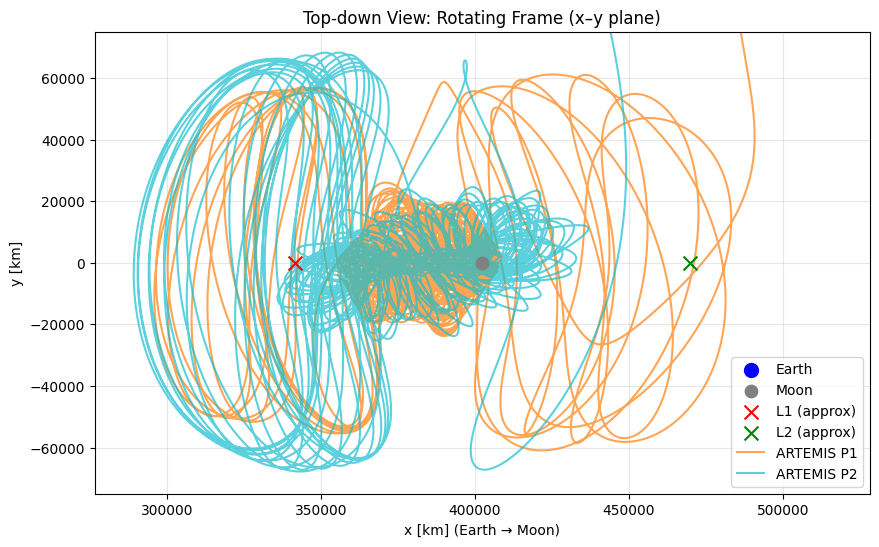

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# r_p1_rot, r_p2_rot, r_moon_rot are assumed to be already computed

# 1. Approximate Lagrange points
d_earth_moon = np.linalg.norm(r_moon_rot[-1])

L1_dist = d_earth_moon * 0.849
L2_dist = d_earth_moon * 1.168

L1_pos = [L1_dist, 0, 0]
L2_pos = [L2_dist, 0, 0]

# 2. 2D plot (top-down view)
fig, ax = plt.subplots(figsize=(10, 6))

ax.scatter(0, 0, c='blue', s=100, label='Earth', zorder=10)
ax.scatter(r_moon_rot[-1, 0], 0, c='gray', s=80, label='Moon', zorder=10)

ax.scatter(L1_pos[0], 0, marker='x', c='red', s=100, label='L1 (approx)', zorder=11)
ax.scatter(L2_pos[0], 0, marker='x', c='green', s=100, label='L2 (approx)', zorder=11)

ax.plot(r_p1_rot[:, 0], r_p1_rot[:, 1], label='ARTEMIS P1', color='tab:orange', alpha=0.7)
ax.plot(r_p2_rot[:, 0], r_p2_rot[:, 1], label='ARTEMIS P2', color='tab:cyan', alpha=0.7)

ax.set_title("Top-down View: Rotating Frame (x–y plane)")
ax.set_xlabel("x [km] (Earth → Moon)")
ax.set_ylabel("y [km]")
ax.axis('equal')
ax.grid(True, alpha=0.3)
ax.legend()

zoom_width = 150000
center_x = d_earth_moon
ax.set_xlim(center_x - zoom_width / 2, center_x + zoom_width / 2)
ax.set_ylim(-zoom_width / 2, zoom_width / 2)

plt.show()
